In [10]:
import sys
sys.path.append('/home/sharedrive/nafi/traffic/lib/python3.9/site-packages')


import pandas as pd
import torch
from table_evaluator import TableEvaluator
import matplotlib.pyplot as plt
from sdv.single_table import GaussianCopulaSynthesizer, TVAESynthesizer
from sdv.metadata import Metadata
import numpy as np
from ctgan import CTGAN
from ctgan import load_demo
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb
from table_evaluator import TableEvaluator
import pickle
import os
import time
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance

In [11]:
cic_train_df = pd.read_csv("/home/sharedrive/nafi/trafficp3/cicidis/datasets/CICIDS_clean_train.csv")
cic_train_df["Label"].value_counts()

Label
BENIGN                       1589924
DoS_Hulk                      161087
PortScan                      111163
DDoS                           89617
DoS_GoldenEye                   7205
FTP-Patator                     5555
SSH-Patator                     4128
DoS_slowloris                   4057
DoS_Slowhttptest                3849
Bot                             1369
Web_Attack__Brute_Force         1055
Web_Attack__XSS                  456
Infiltration                      25
Web_Attack__Sql_Injection         15
Heartbleed                         8
Name: count, dtype: int64

In [12]:
cic_test_df = pd.read_csv("/home/sharedrive/nafi/trafficp3/cicidis/datasets/CICIDS_clean_test.csv")
cic_test_df["Label"].value_counts()

Label
BENIGN                       681396
DoS_Hulk                      69037
PortScan                      47641
DDoS                          38408
DoS_GoldenEye                  3088
FTP-Patator                    2380
SSH-Patator                    1769
DoS_slowloris                  1739
DoS_Slowhttptest               1650
Bot                             587
Web_Attack__Brute_Force         452
Web_Attack__XSS                 196
Infiltration                     11
Web_Attack__Sql_Injection         6
Heartbleed                        3
Name: count, dtype: int64

In [13]:
cic_train_df.drop(columns=["Init_Win_bytes_forward", "Flow_IAT_Min"], inplace=True)
cic_test_df.drop(columns=["Init_Win_bytes_forward", "Flow_IAT_Min"], inplace=True)
cic_train_df.shape, cic_test_df.shape

((1979513, 23), (848363, 23))

In [14]:
def replace_negatives_with_positive_mean(df):
    df_copy = df.copy()
    
    for col in df_copy.columns:
        if col == "Label":
            continue
        if pd.api.types.is_numeric_dtype(df_copy[col]):
            # calculate the mean of positive values in the column
            positive_values = df_copy[col][df_copy[col] >= 0]
            if not positive_values.empty:
                positive_mean = positive_values.mean()
                # replace negatives with the mean of positive values
                df_copy.loc[df_copy[col] < 0, col] = positive_mean
            else:
                print(f"Column '{col}' has no positive values. Negatives remain unchanged.")
    
    return df_copy

cic_train_df = replace_negatives_with_positive_mean(cic_train_df)
cic_test_df = replace_negatives_with_positive_mean(cic_test_df)

import pandas as pd
from tqdm import tqdm

def analyze_negative_values(df, show_values=False, sample=10):
    # Select only numeric columns to optimize processing
    numeric_cols = df.select_dtypes(include=['number']).columns
    summary = []
    
    # Use tqdm for progress bar (only in Jupyter)
    for col in tqdm(numeric_cols, desc="Processing columns"):
        negative_count = (df[col] < 0).sum()
        result = {"Feature": col, "Negative Count": negative_count}
        
        if show_values and negative_count > 0:
            negatives = df[col][df[col] < 0]
            result["Sample Values"] = negatives.head(sample).tolist()
        
        summary.append(result)
    
    return pd.DataFrame(summary)

analyze_negative_values(cic_train_df), analyze_negative_values(cic_test_df)

Processing columns: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 902.23it/s]


(                        Feature  Negative Count
 0                 Flow_Duration               0
 1   Total_Length_of_Bwd_Packets               0
 2         Bwd_Packet_Length_Max               0
 3        Bwd_Packet_Length_Mean               0
 4                  Flow_Bytes/s               0
 5                Flow_Packets/s               0
 6                 Flow_IAT_Mean               0
 7                  Flow_IAT_Std               0
 8                  Flow_IAT_Max               0
 9                 Fwd_IAT_Total               0
 10                 Fwd_IAT_Mean               0
 11                  Fwd_IAT_Std               0
 12                  Fwd_IAT_Max               0
 13                  Fwd_IAT_Min               0
 14                Fwd_Packets/s               0
 15                Bwd_Packets/s               0
 16            Max_Packet_Length               0
 17           Packet_Length_Mean               0
 18          Average_Packet_Size               0
 19         Avg_Bwd_

In [30]:
label_encoder = LabelEncoder()
scaler = StandardScaler()

In [31]:
def generate_data_for_classes_tvae(df, classes, num_samples, num_epochs=500):
    synthetic_data = pd.DataFrame()
    metadata = Metadata.detect_from_dataframe(data=df)
    for cls in classes:
        selected_df = df[df["Label"] == cls]
        synthesizer = TVAESynthesizer(metadata, epochs=num_epochs, verbose=True)
        synthesizer.fit(selected_df)
        samples = synthesizer.sample(num_samples)
        
        synthetic_data = pd.concat([synthetic_data, samples])
    return synthetic_data

In [32]:
small_classes = ['Web_Attack__XSS', 'Web_Attack__Brute_Force',
       'Web_Attack__Sql_Injection', 'Infiltration', 'Heartbleed', 'Bot']
save_path = "/home/sharedrive/nafi/trafficp3/cicidis"

def save_label_encoder(le, file_name):
    with open(f'{save_path}/models/{file_name}_label_encoder.pkl', 'wb') as le_file:
        pickle.dump(le, le_file)

def save_scaler(scaler, file_name):
    with open(f'{save_path}/models/{file_name}_scaler.pkl', 'wb') as scaler_file:
        pickle.dump(scaler, scaler_file)
    
def tvae_train(train_df, epochi, file_name, reduced_test_df, rounds=0):

    for num_sample in [1000]:
        print(f"{file_name} epoch={epochi} samples={num_sample} round={rounds}")

        synthetic_file_path = f"{save_path}/datasets/{file_name}sample{num_sample}epoch{epochi}rounds{rounds}.csv"
        
        if os.path.exists(synthetic_file_path):
            print(f"Synthetic data already exists: {synthetic_file_path}")
            synthetic_data_df = pd.read_csv(synthetic_file_path)
        else:
            start_time = time.time()
            print("Generating synthetic data...") 
            synthetic_data = generate_data_for_classes_tvae(train_df, small_classes, num_sample, epochi)

            # save and load synthetic data
            synthetic_data.to_csv(f'{save_path}/datasets/{file_name}sample{num_sample}epoch{epochi}rounds{rounds}.csv', index=False)
            synthetic_data_df = pd.read_csv(synthetic_file_path)
            
            elapsed_time = time.time() - start_time
            print(f"Execution time for generating data: {elapsed_time:.2f} seconds")

        # combine synthetic and real data
        combined_train_synth_df = pd.concat([train_df, synthetic_data_df], axis=0, ignore_index=True)

        # divide to x_train and y_train from reduced_train_df
        x_train = combined_train_synth_df.drop(columns=["Label"])
        y_train = combined_train_synth_df["Label"]
        x_test = reduced_test_df.drop(columns=["Label"])
        y_test = reduced_test_df["Label"]
        
        y_train = label_encoder.fit_transform(y_train) # Encode string labels into numeric format
        y_test = label_encoder.transform(y_test)
        x_train = scaler.fit_transform(x_train) # Standardize the features
        x_test = scaler.transform(x_test)
        save_label_encoder(label_encoder, file_name)
        save_scaler(scaler, file_name)

        RF_model = RandomForestClassifier(random_state=1002, verbose=2)
        RF_model.fit(x_train, y_train) #For sklearn no one hot encoding

        pred_rf = RF_model.predict(x_test)


        pickle.dump(RF_model, open(f'{save_path}/models/{file_name}sample{num_sample}epoch{epochi}rounds{rounds}.pkl', 'wb'))

        print(f"Classification Report for Sample Size {num_sample}:")
        print(classification_report(y_test, pred_rf, digits=4, target_names=label_encoder.classes_))

In [33]:
tvae_train(train_df=cic_train_df, epochi=1500, file_name='synthetic_from_cicids_tvae', reduced_test_df=cic_test_df, rounds=11)


synthetic_from_cicids_tvae epoch=1500 samples=1000 round=11
Generating synthetic data...


/home/sharedrive/nafi/traffic/lib/python3.9/site-packages/sdv/single_table/base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
Loss: -160.870: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:32<00:00,  9.87it/s]


Execution time for generating data: 536.32 seconds
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 10

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  4.2min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.2s


Classification Report for Sample Size 1000:
                           precision    recall  f1-score   support

                   BENIGN     0.9956    0.9902    0.9929    681396
                      Bot     0.8006    0.4923    0.6097       587
                     DDoS     0.9989    0.9985    0.9987     38408
            DoS_GoldenEye     0.9809    0.9812    0.9811      3088
                 DoS_Hulk     0.9167    0.9767    0.9457     69037
         DoS_Slowhttptest     0.9482    0.9873    0.9673      1650
            DoS_slowloris     0.9983    0.9954    0.9968      1739
              FTP-Patator     0.9979    0.9878    0.9928      2380
               Heartbleed     1.0000    0.6667    0.8000         3
             Infiltration     0.6364    0.6364    0.6364        11
                 PortScan     0.9934    0.9995    0.9965     47641
              SSH-Patator     0.9956    0.5150    0.6788      1769
  Web_Attack__Brute_Force     0.7271    0.7013    0.7140       452
Web_Attack__Sql_I

In [34]:
tvae_train(train_df=cic_train_df, epochi=1500, file_name='synthetic_from_cicids_tvae', reduced_test_df=cic_test_df, rounds=22)


synthetic_from_cicids_tvae epoch=1500 samples=1000 round=22
Generating synthetic data...


/home/sharedrive/nafi/traffic/lib/python3.9/site-packages/sdv/single_table/base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
Loss: -163.409: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:32<00:00,  9.86it/s]


Execution time for generating data: 528.13 seconds
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 10

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  4.0min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.2s


Classification Report for Sample Size 1000:
                           precision    recall  f1-score   support

                   BENIGN     0.9956    0.9902    0.9929    681396
                      Bot     0.7913    0.4974    0.6109       587
                     DDoS     0.9990    0.9986    0.9988     38408
            DoS_GoldenEye     0.9809    0.9825    0.9817      3088
                 DoS_Hulk     0.9166    0.9767    0.9457     69037
         DoS_Slowhttptest     0.9482    0.9867    0.9670      1650
            DoS_slowloris     0.9977    0.9954    0.9965      1739
              FTP-Patator     0.9979    0.9878    0.9928      2380
               Heartbleed     1.0000    1.0000    1.0000         3
             Infiltration     0.6364    0.6364    0.6364        11
                 PortScan     0.9934    0.9995    0.9964     47641
              SSH-Patator     0.9967    0.5150    0.6791      1769
  Web_Attack__Brute_Force     0.7289    0.7080    0.7183       452
Web_Attack__Sql_I

In [35]:
tvae_train(train_df=cic_train_df, epochi=1500, file_name='synthetic_from_cicids_tvae', reduced_test_df=cic_test_df, rounds=33)


synthetic_from_cicids_tvae epoch=1500 samples=1000 round=33
Generating synthetic data...


/home/sharedrive/nafi/traffic/lib/python3.9/site-packages/sdv/single_table/base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
Loss: -133.480: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:49<00:00, 30.33it/s]
/home/nafi/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Loss: -165.341: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [02:31<00:00,  9.89it/s]


Execution time for generating data: 527.82 seconds
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 10

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  4.2min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    5.3s


Classification Report for Sample Size 1000:
                           precision    recall  f1-score   support

                   BENIGN     0.9956    0.9902    0.9929    681396
                      Bot     0.7906    0.4889    0.6042       587
                     DDoS     0.9990    0.9985    0.9988     38408
            DoS_GoldenEye     0.9819    0.9822    0.9820      3088
                 DoS_Hulk     0.9167    0.9767    0.9457     69037
         DoS_Slowhttptest     0.9475    0.9848    0.9658      1650
            DoS_slowloris     0.9977    0.9954    0.9965      1739
              FTP-Patator     0.9979    0.9878    0.9928      2380
               Heartbleed     1.0000    1.0000    1.0000         3
             Infiltration     0.7000    0.6364    0.6667        11
                 PortScan     0.9935    0.9995    0.9965     47641
              SSH-Patator     0.9967    0.5150    0.6791      1769
  Web_Attack__Brute_Force     0.7140    0.7013    0.7076       452
Web_Attack__Sql_I

JSD:  [{0.3684736134981072, 'Web_Attack__XSS'}, {0.2065738735442076, 'Web_Attack__Brute_Force'}, {0.4468836680984569, 'Web_Attack__Sql_Injection'}, {0.43790756514074486, 'Infiltration'}, {0.39624780554350497, 'Heartbleed'}, {0.3736906602477004, 'Bot'}]
Mean JSD: 0.3716295310121203
EMD:  [{'Web_Attack__XSS', 0.010388002325860317}, {0.009868952008631212, 'Web_Attack__Brute_Force'}, {0.033535849865795726, 'Web_Attack__Sql_Injection'}, {0.01011549183855636, 'Infiltration'}, {0.019871774818545594, 'Heartbleed'}, {0.0034301830312499348, 'Bot'}]
Mean: 0.014535042314773193


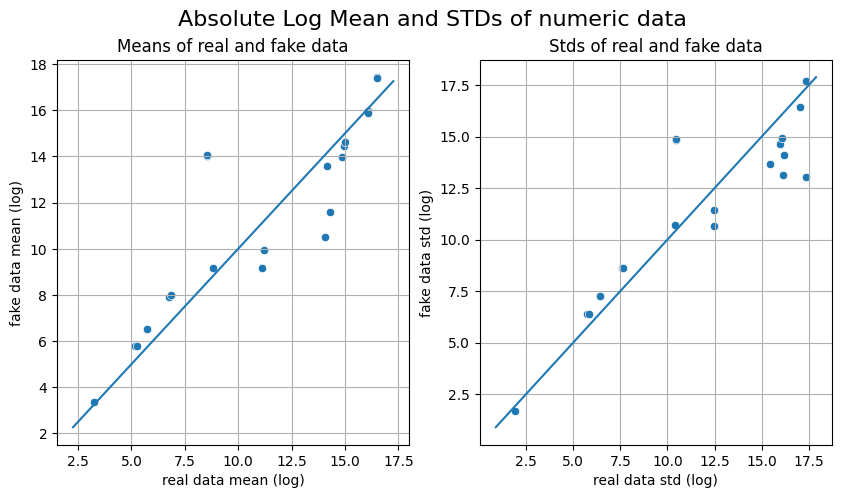

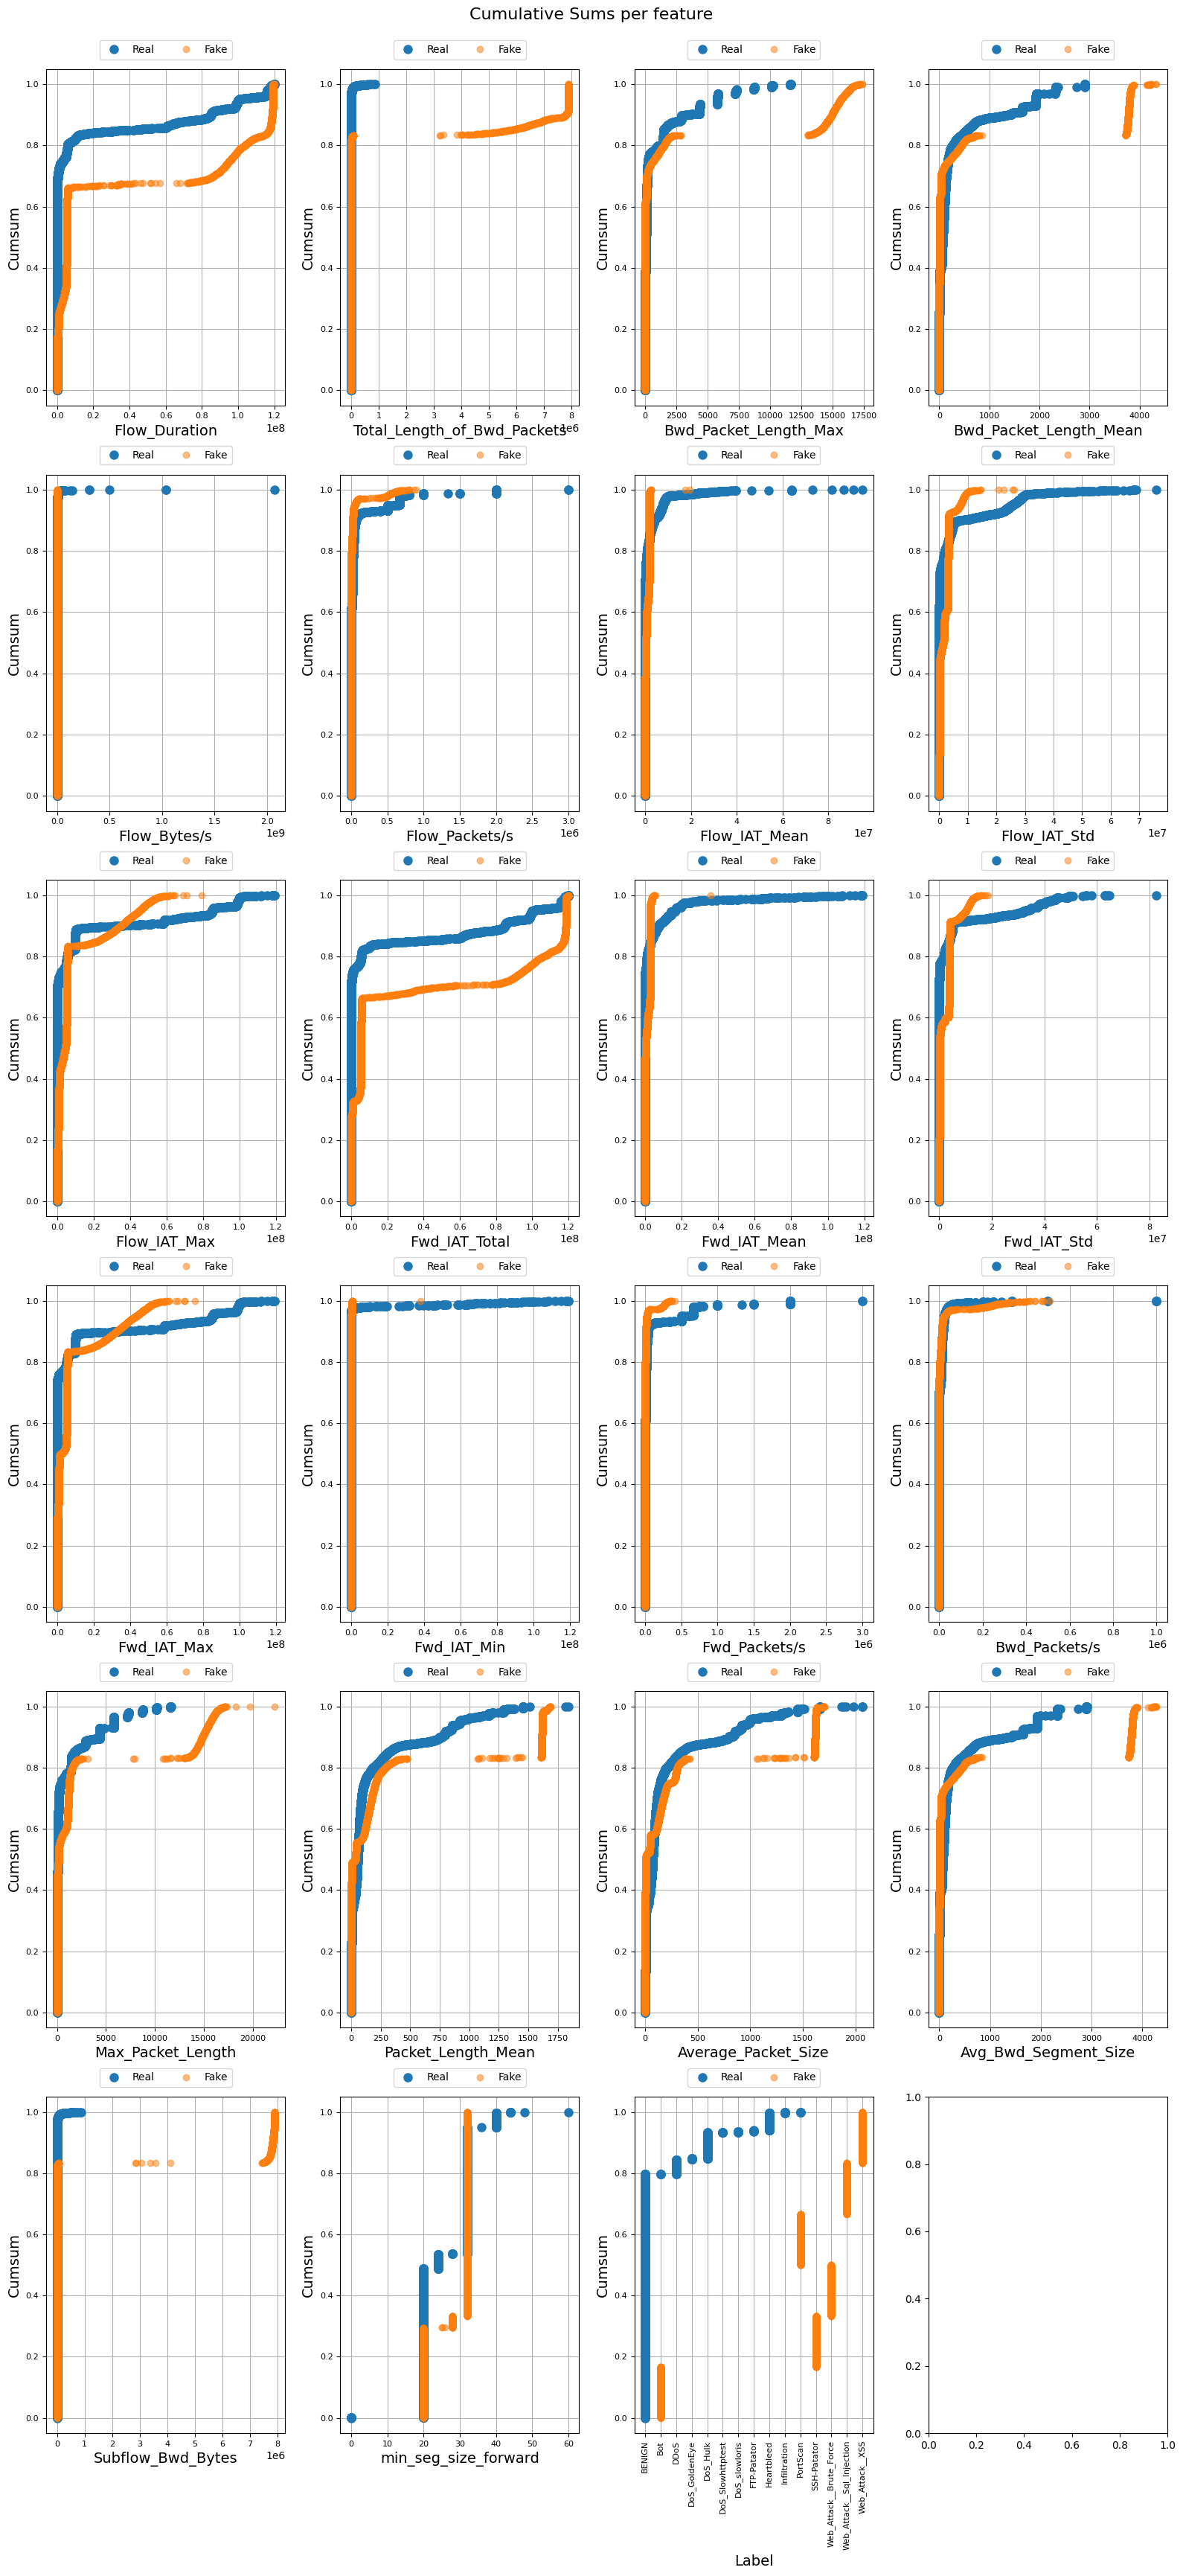

KeyboardInterrupt: 

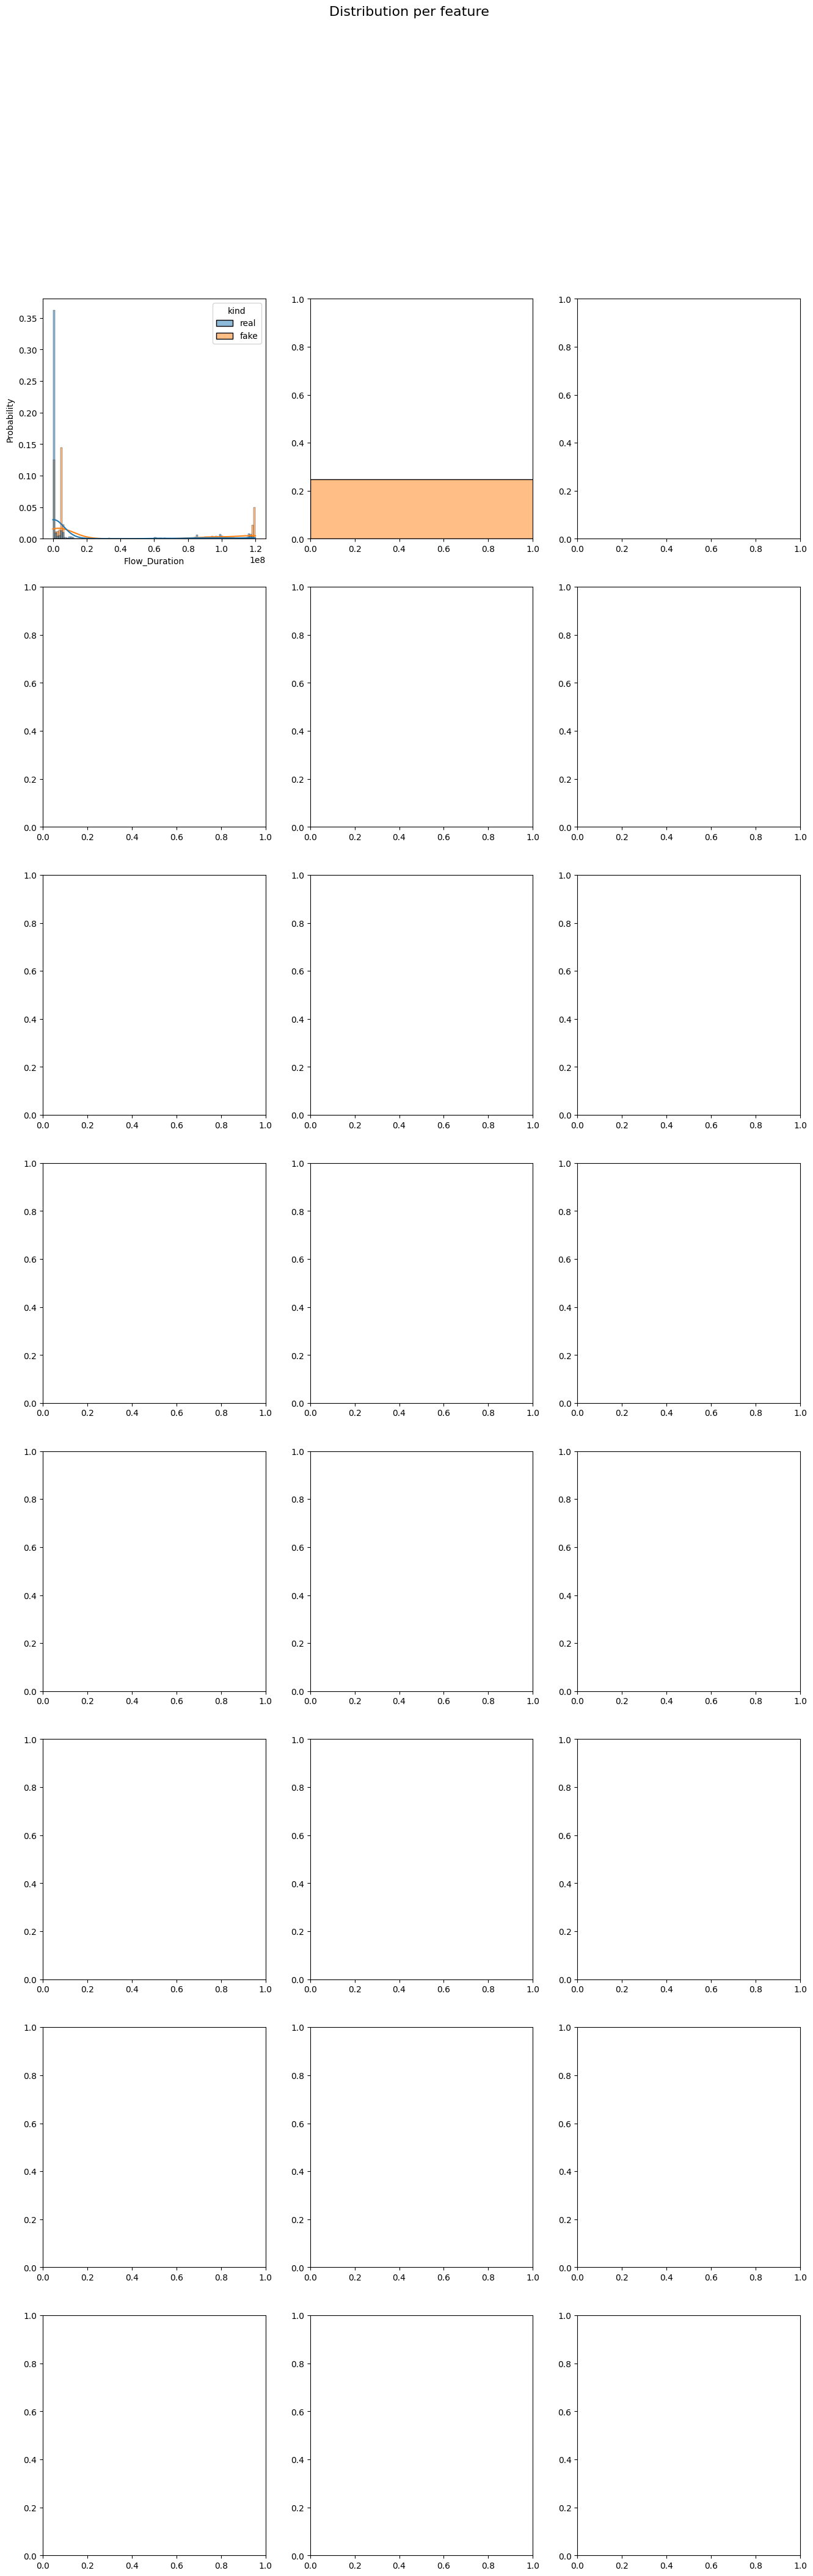

In [15]:
small_classes = ['Web_Attack__XSS', 'Web_Attack__Brute_Force',
       'Web_Attack__Sql_Injection', 'Infiltration', 'Heartbleed', 'Bot']

def calculate_emd(real_data, synthetic_data, bins=20):
    emd_scores = {}
    for column in real_data.columns:
        real_hist, bin_edges = np.histogram(real_data[column], bins=bins, density=True)
        synthetic_hist, _ = np.histogram(synthetic_data[column], bins=bin_edges, density=True)
        
        # Avoid division by zero by adding a small value
        real_hist += 1e-8
        synthetic_hist += 1e-8
        
        # Normalize histograms to form probability distributions
        real_prob = real_hist / np.sum(real_hist)
        synthetic_prob = synthetic_hist / np.sum(synthetic_hist)
        
        
        emd_scores[column] = wasserstein_distance(real_prob, synthetic_prob)

    mean_emd = np.mean(list(emd_scores.values()))
    return mean_emd

def calculate_classwise_emd(real_data, synthetic_data):
    emd_store = []
    for cls in small_classes:
        syn = synthetic_data[synthetic_data['Label']==cls].copy()
        real = real_data[real_data['Label']==cls].copy()
        
        syn.drop(columns='Label', inplace=True)
        real.drop(columns='Label', inplace=True)

        emd = calculate_emd(real, syn)
        emd_store.append({cls, emd})
    print("EMD: ", emd_store)
    print(f'Mean: {np.mean([emd for item in emd_store for emd in item if isinstance(emd, (int, float))])}')
    
def calculate_jsd(real_data, synthetic_data, bins=20):
    jsd_scores = {}
    for column in real_data.columns:
        real_hist, bin_edges = np.histogram(real_data[column], bins=bins, density=True)
        synthetic_hist, _ = np.histogram(synthetic_data[column], bins=bins, density=True)
        
        jsd = jensenshannon(real_hist, synthetic_hist)
        
        jsd_scores[column] = jsd

    mean_jsd = np.mean(list(jsd_scores.values()))
    return mean_jsd

def calculate_classwise_jsd(real_data, synthetic_data):
    jsd_store = []
    for cls in small_classes:
        syn = synthetic_data[synthetic_data['Label'] == cls].copy()
        real = real_data[real_data['Label'] == cls].copy()
        
        syn.drop(columns='Label', inplace=True)
        real.drop(columns='Label', inplace=True)

        jsd = calculate_jsd(real, syn)
        jsd_store.append({cls, jsd}) 
    
    print("JSD: ", jsd_store)
    # Extract JSD values from the sets and compute the mean
    jsd_values = [val for item in jsd_store for val in item if isinstance(val, (int, float))]
    print(f'Mean JSD: {np.mean(jsd_values)}')

save_path = "/home/sharedrive/nafi/trafficp3/cicidis"
def table_evaluator(file_name="synthetic_from_cicids_tvae", epochi=1500, num_sample=1000, rounds=1):
    synthetic_file_path = f"{save_path}/datasets/{file_name}sample{num_sample}epoch{epochi}rounds{rounds}.csv"
    syn_data = pd.read_csv(synthetic_file_path)
    calculate_classwise_jsd(cic_train_df, syn_data)
    calculate_classwise_emd(cic_train_df, syn_data)
    table_evaluator = TableEvaluator(cic_train_df, syn_data)
    print(table_evaluator.visual_evaluation())
table_evaluator(rounds=11)

JSD:  [{0.37655155577782035, 'Web_Attack__XSS'}, {0.20382335696508472, 'Web_Attack__Brute_Force'}, {0.4273440532574954, 'Web_Attack__Sql_Injection'}, {0.4255682367672224, 'Infiltration'}, {0.42071743198290723, 'Heartbleed'}, {0.36143306397513714, 'Bot'}]
Mean JSD: 0.3692396164542779
EMD:  [{0.010130030809654907, 'Web_Attack__XSS'}, {0.0072732356877388245, 'Web_Attack__Brute_Force'}, {0.03261409406525809, 'Web_Attack__Sql_Injection'}, {0.010055000499425443, 'Infiltration'}, {0.019457180469844015, 'Heartbleed'}, {0.002255701516343814, 'Bot'}]
Mean: 0.013630873841377516


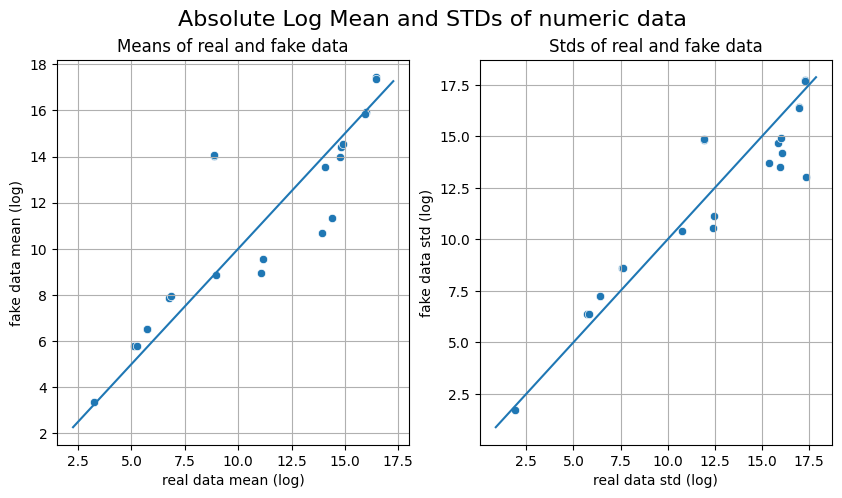

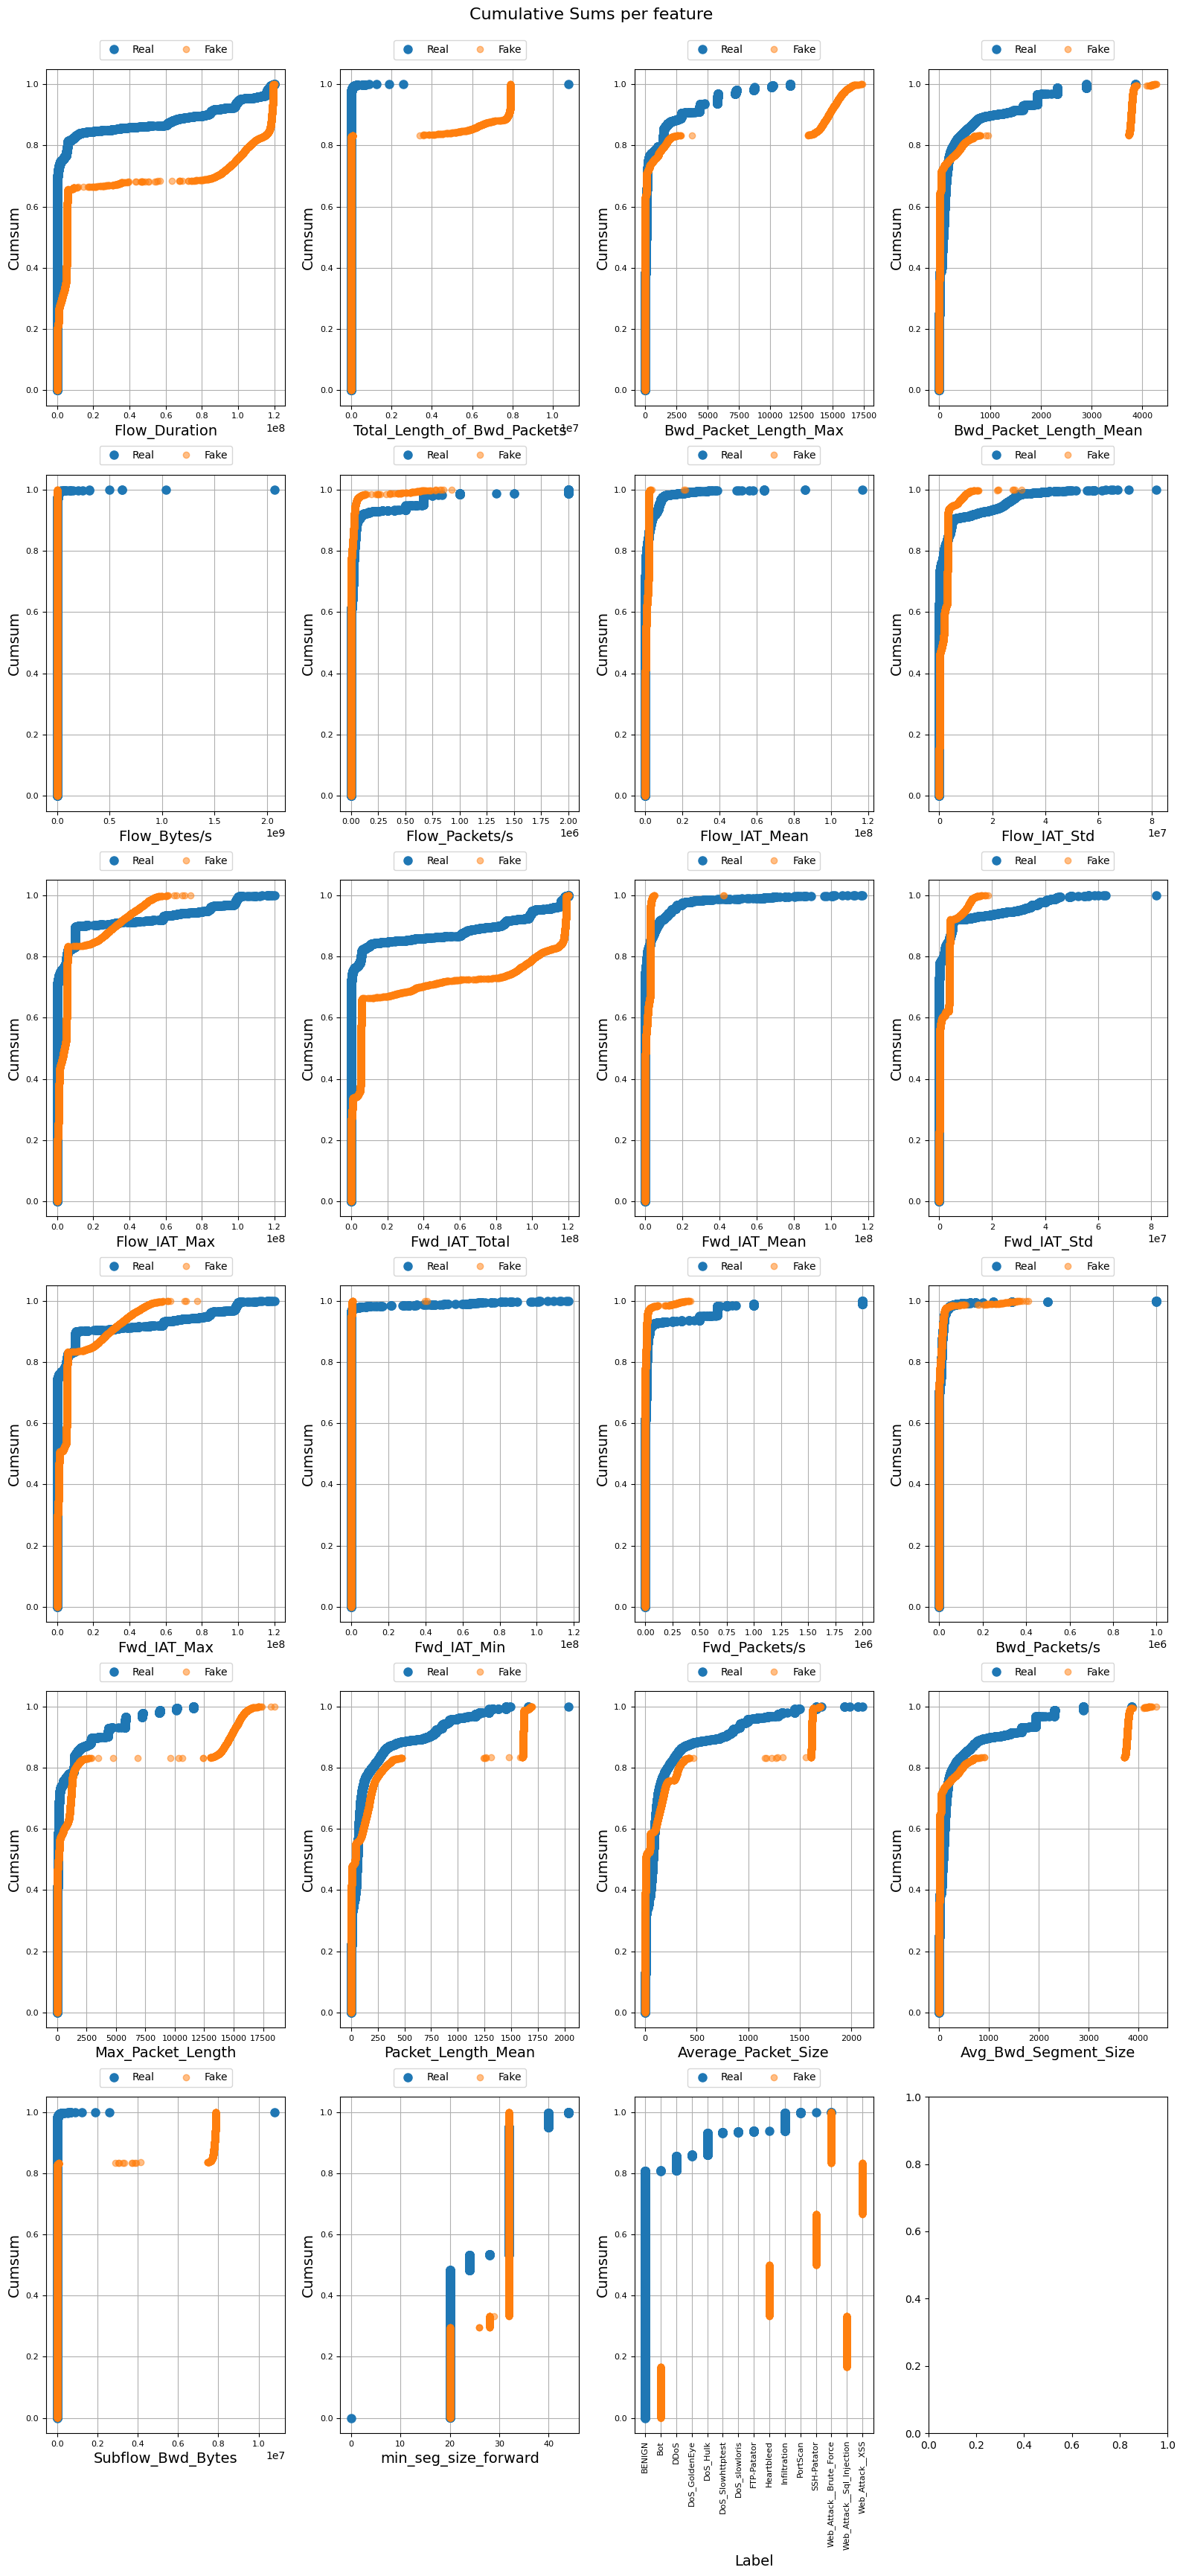

KeyboardInterrupt: 

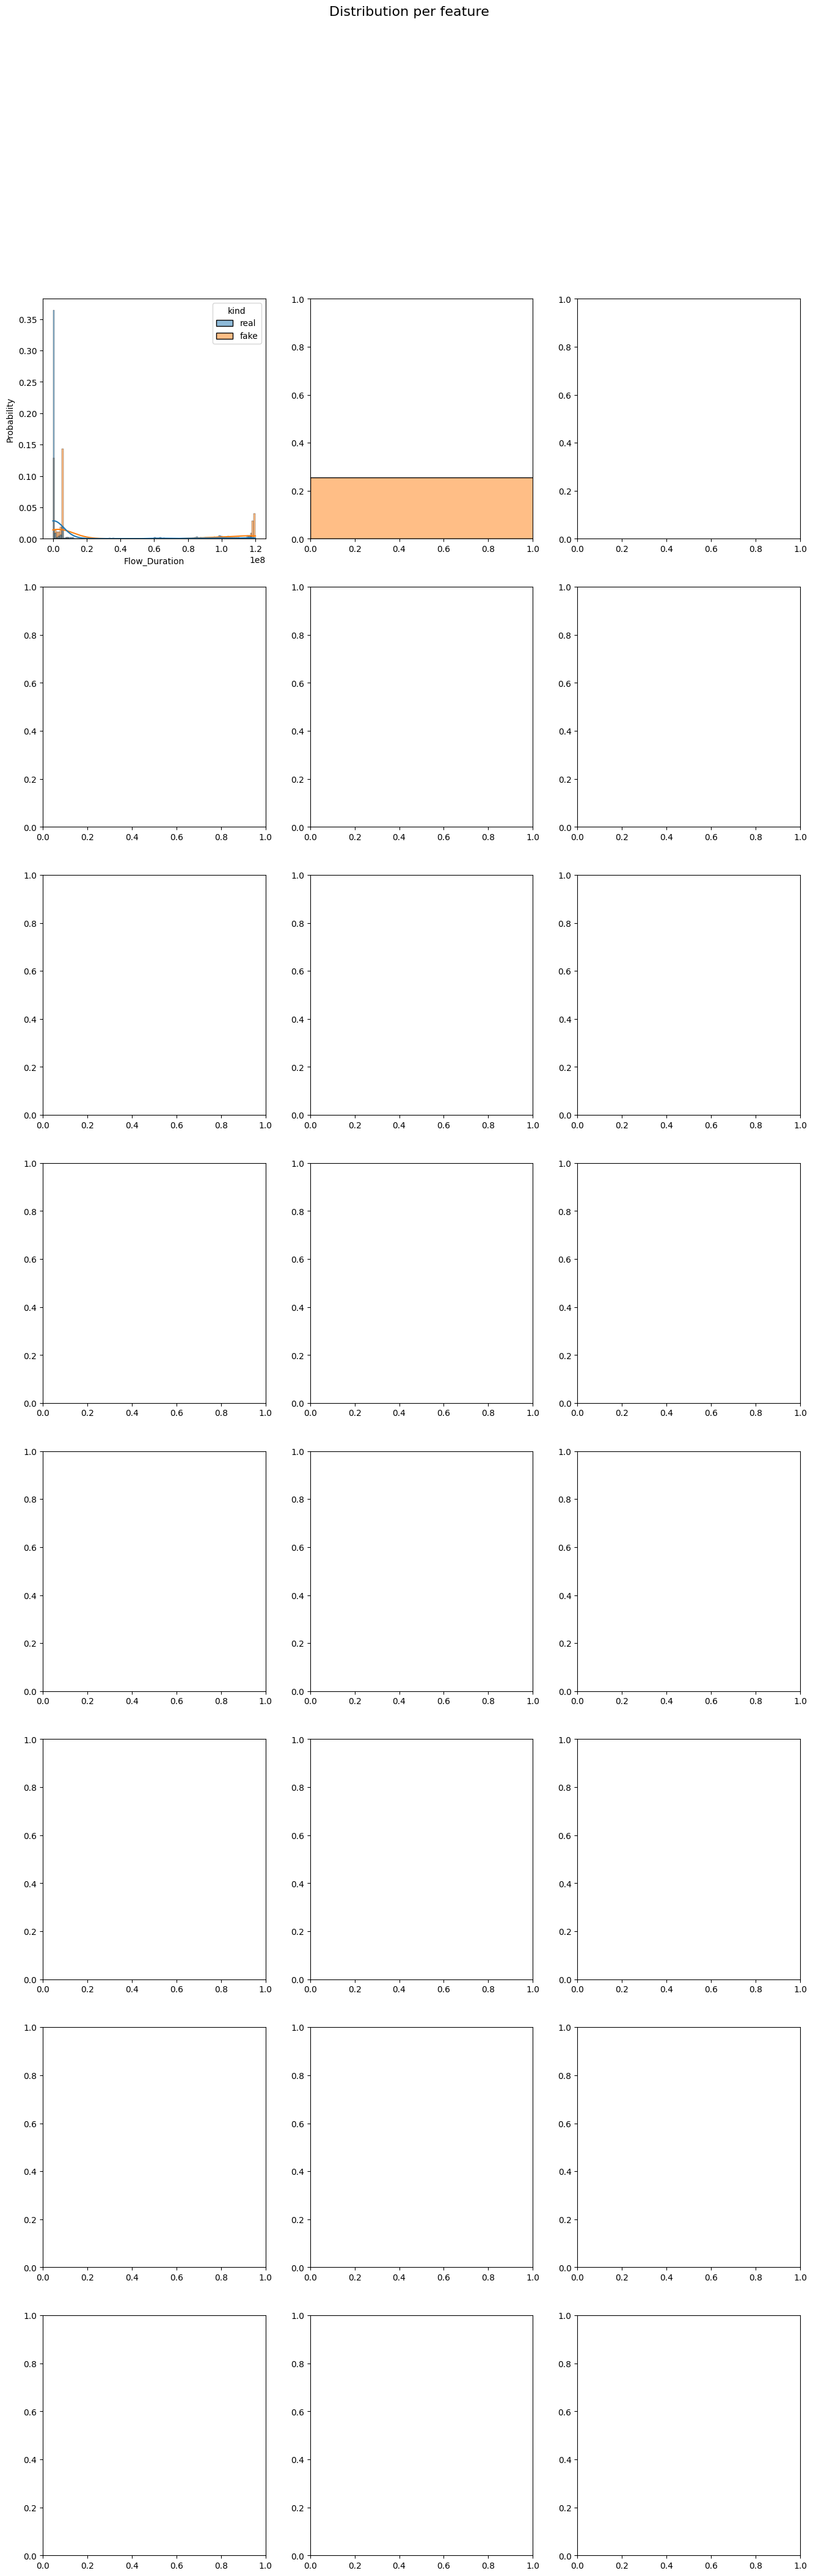

In [16]:
table_evaluator(rounds=22)

JSD:  [{0.19016778417170244, 'Web_Attack__XSS'}, {0.20331875414320413, 'Web_Attack__Brute_Force'}, {0.4462153166221237, 'Web_Attack__Sql_Injection'}, {0.33475678821434535, 'Infiltration'}, {0.43221290022929093, 'Heartbleed'}, {0.3560231457558018, 'Bot'}]
Mean JSD: 0.32711578152274473
EMD:  [{'Web_Attack__XSS', 0.008216147466203643}, {0.011017040336920912, 'Web_Attack__Brute_Force'}, {0.03242508806946273, 'Web_Attack__Sql_Injection'}, {0.010696627880047065, 'Infiltration'}, {0.01919292502155429, 'Heartbleed'}, {0.005839991912028595, 'Bot'}]
Mean: 0.014564636781036205


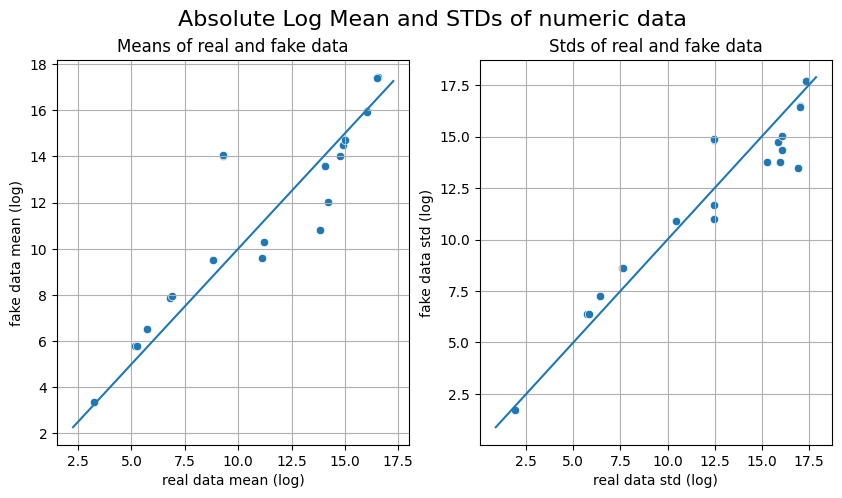

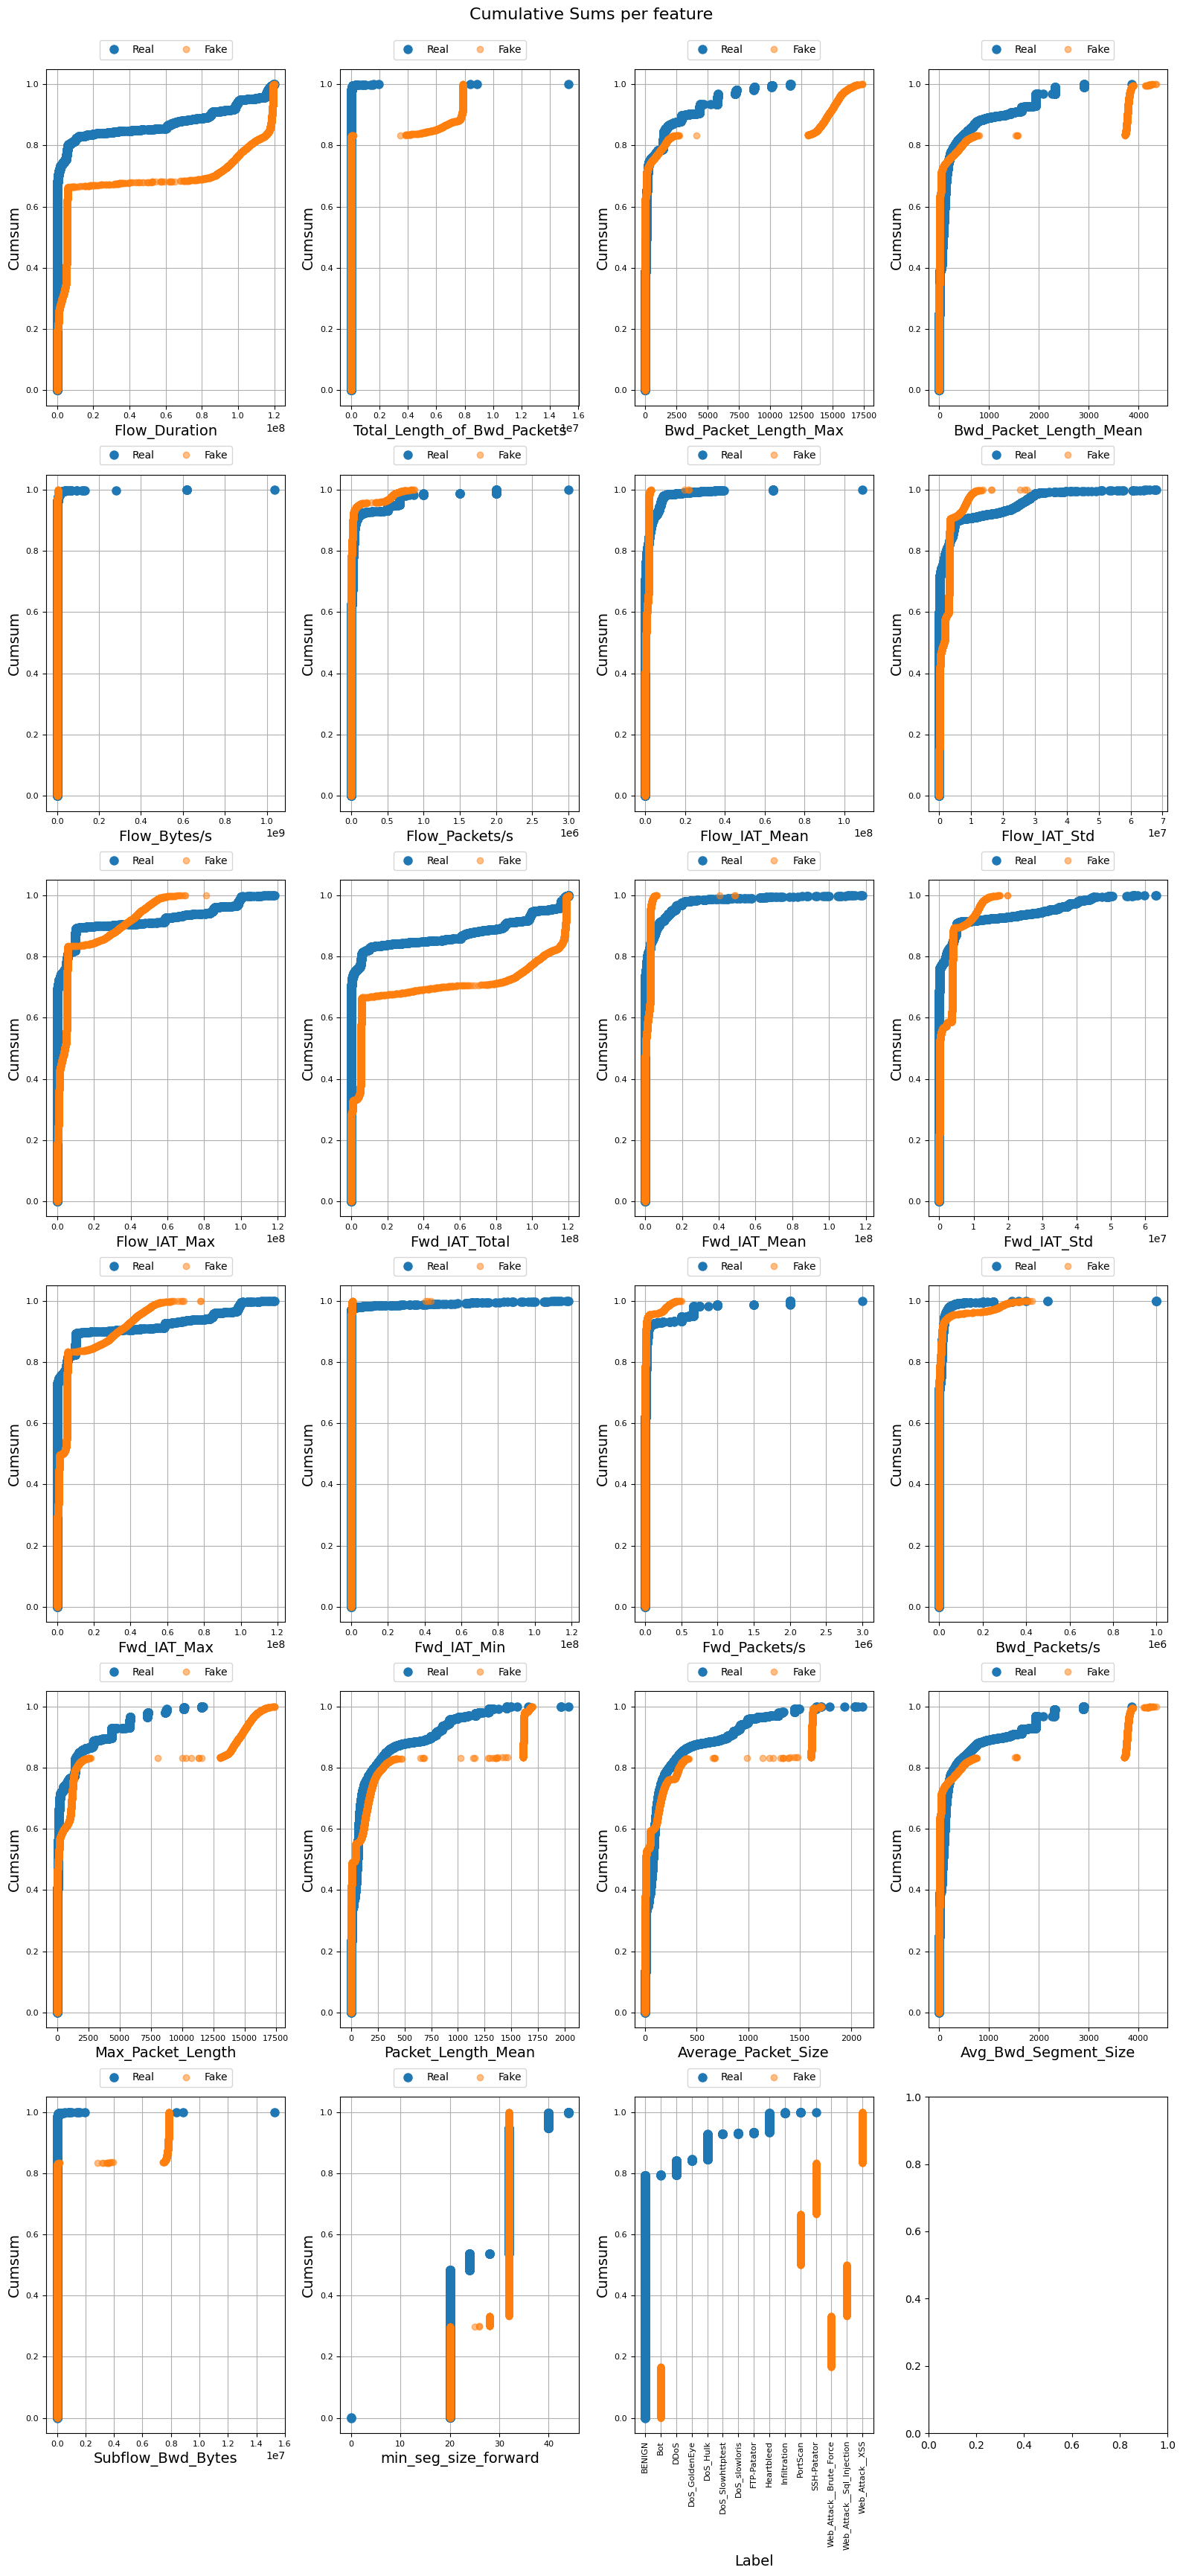

KeyboardInterrupt: 

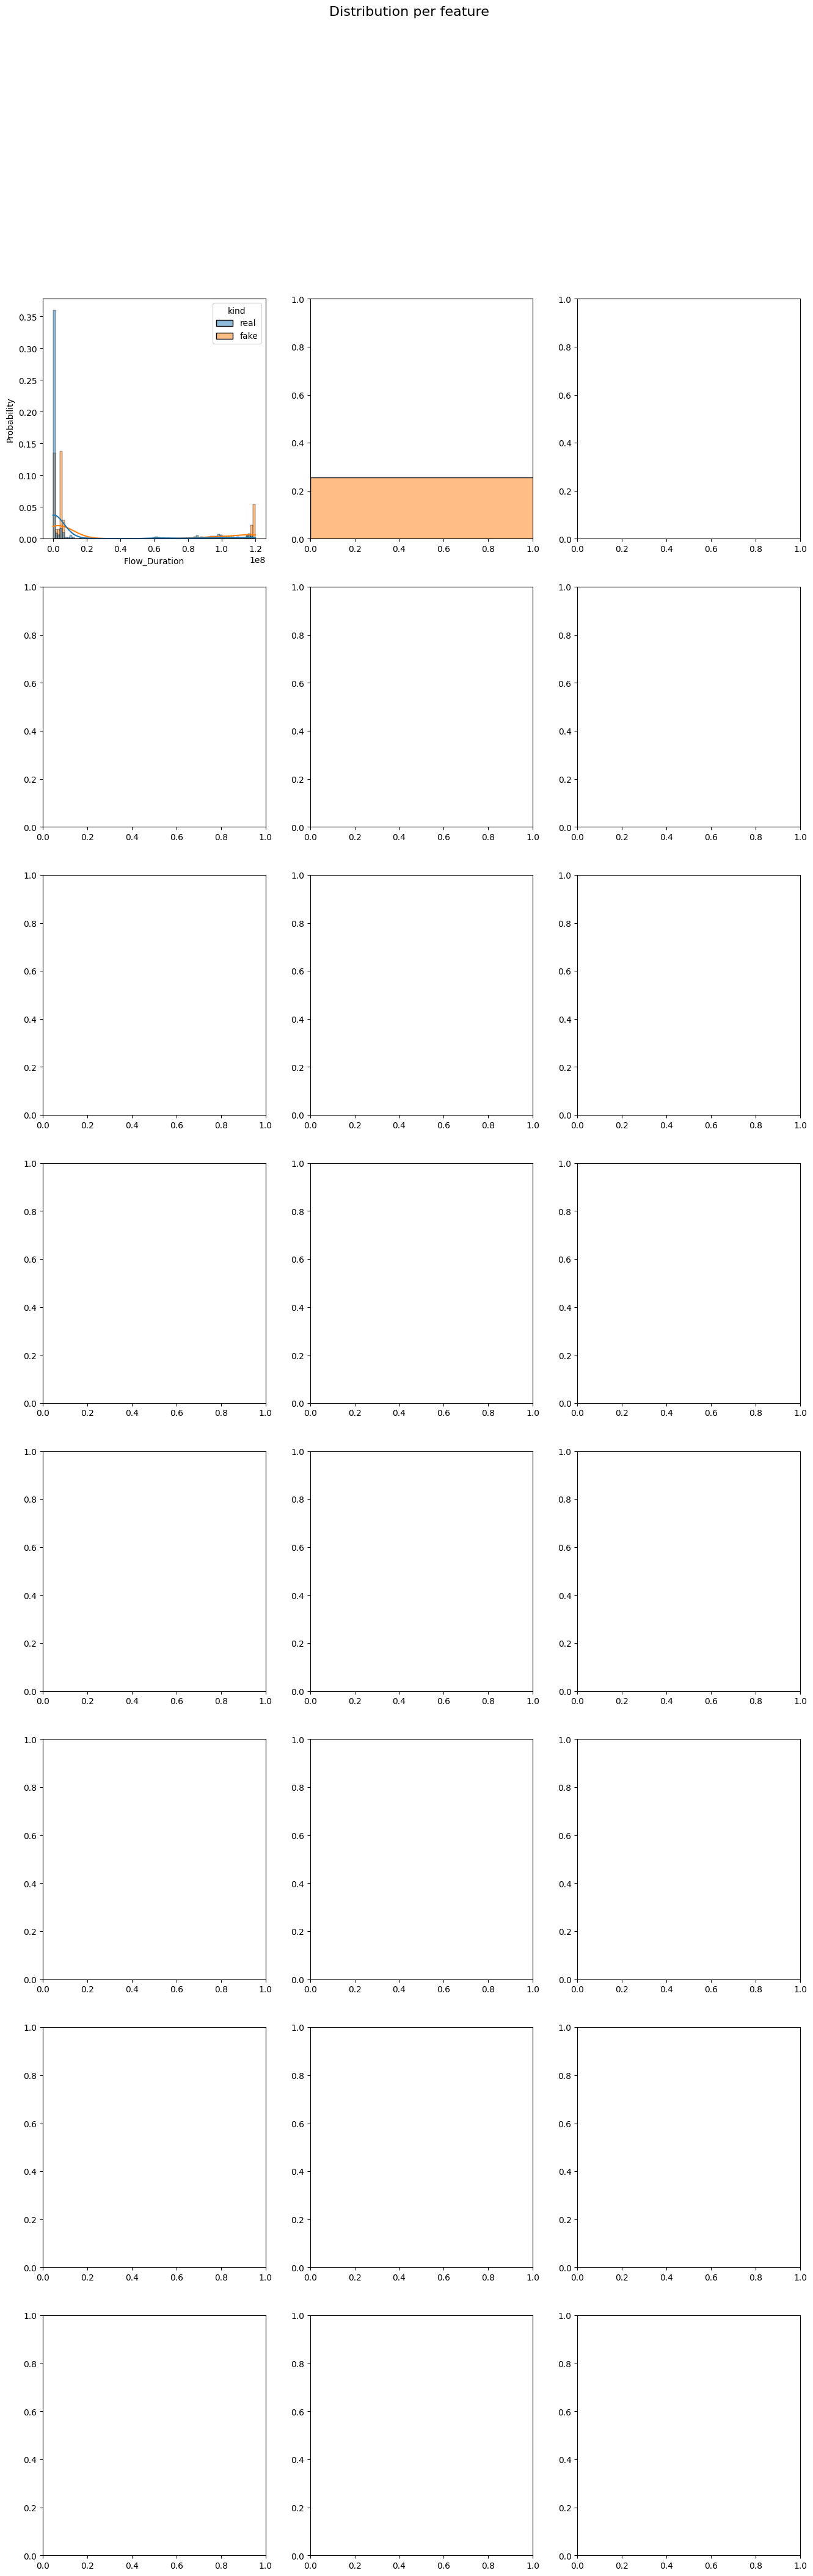

In [17]:
table_evaluator(rounds=33)